# Путешествие по Спрингфилду
**Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**


Сегодня вам предстоит помочь телекомпании FOX в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персонажи менялись вместе с изменяющимися графическими технологиями, и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.

 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)

# Важное замечание по поводу датасета

Я увидел сильный дисбланас классов и решил частично исправить его вручную, найдя картинки для наиболее редких классов. Картинки искал просто в интернете, в тестовую выборку не заглядывал.

Вот дополнительные картинки https://drive.google.com/drive/folders/1iFZiy1q_k1UuHbBAGn-uGMqE2oi3Bfh3?usp=sharing

# Подготовка

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import datetime
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import f1_score, accuracy_score
import PIL
import time
from collections import Counter
from matplotlib import colors, pyplot as plt
%matplotlib inline

# мы будем игнорировать warnings
import warnings
#warnings.filterwarnings(action='ignore', category=DeprecationWarning)


train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = torch.device("cpu")
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = torch.device("cuda:0")

DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
TRAIN_DIR = Path('simpsons_dataset')
TEST_DIR = Path('testset')
CNN_COLOR_NORM = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

CUDA is available!  Training on GPU ...


# Мини-EDA, подготовка датасета

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

Ниже мы исспользуем враппер над датасетом для [удобной работы](https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/). Вам стоит понимать, что происходит с LabelEncoder и с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [2]:
label_encoder = LabelEncoder()
label_encoder.fit([path.parent.name for path in sorted(list(TRAIN_DIR.rglob('*.jpg')))])
label_encoder.classes_

array(['abraham_grampa_simpson', 'agnes_skinner',
       'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson',
       'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum',
       'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel',
       'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson',
       'kent_brockman', 'krusty_the_clown', 'lenny_leonard',
       'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson',
       'martin_prince', 'mayor_quimby', 'milhouse_van_houten',
       'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz',
       'otto_mann', 'patty_bouvier', 'principal_skinner',
       'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum',
       'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird',
       'troy_mcclure', 'waylon_smithers'], dtype='<U24')

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        if mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.files = files
        self.mode = mode
        if mode == 'train':
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomRotation(20, interpolation=transforms.InterpolationMode.BILINEAR),
                #transforms.Resize((int(RESCALE_SIZE * 1.25), int(RESCALE_SIZE * 1.25))),
                transforms.Resize((int(RESCALE_SIZE), int(RESCALE_SIZE))),
                #transforms.RandomCrop(RESCALE_SIZE),
                transforms.RandomHorizontalFlip(),
                transforms.Normalize(*CNN_COLOR_NORM)
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((int(RESCALE_SIZE), int(RESCALE_SIZE))),
                transforms.Normalize(*CNN_COLOR_NORM)
            ])
        self.len_ = len(self.files)
        if self.mode != 'test':
            self.labels_full = [path.parent.name for path in self.files]
            self.labels = label_encoder.transform(self.labels_full)

    def __len__(self):
        return self.len_
      
    def __getitem__(self, index):
        image = Image.open(self.files[index])
        image.load()
        x = np.array(image, dtype='float32') / 255
        x = self.transform(x)

        if self.mode == 'train':
            #noise = torch.randn(3, 224,224)
            #percent_noise = 0.0
            #x = noise * percent_noise + x
            pass

        if self.mode == 'test':
            return x
        else:
            y = self.labels[index]
            return x, y

Посмотрим на наш датасет.

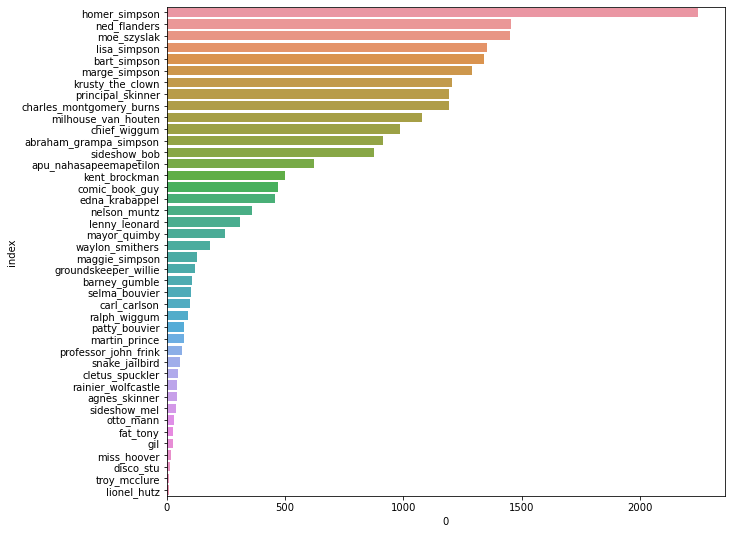

In [4]:
l = sorted(list(TRAIN_DIR.rglob('*.jpg')))
l = [str(s).split('\\')[-2] for s in l]
class_counter = Counter(l)
tmp = pd.Series(class_counter).sort_values(ascending=False).to_frame()
tmp = tmp.reset_index()
fig = plt.figure(figsize=(10,9))
fig.patch.set_facecolor('xkcd:white')
sns.barplot(data=tmp, y='index', x=0);

Наблюдаем очень сильный дисбаланс классов.

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array(CNN_COLOR_NORM[0])
    std = np.array(CNN_COLOR_NORM[1])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
from sklearn.model_selection import train_test_split

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = label_encoder.transform([path.parent.name for path in train_val_files])
train_files, val_files = train_test_split(train_val_files, test_size=0.2, stratify=train_val_labels, shuffle=True, random_state=2077)

In [7]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

Для борьбы с дисбалансом сделаем сэмплирование, которое с повышенным шансом выдает редкие классы во время обучения. Вероятность выдачи класса обратно пропорциональна корню из его частоты. Корень - чтобы немного сгладить работу алгоритма, чтобы не плодить слишком многократно редкие классы.

(Эта штука - неудачная попытка. В работе дальше использована взвешенная функция потерь для борьбы с дисбалансом)

In [8]:
# a = pd.DataFrame(train_dataset.labels).rename(columns={0:'label'})
# a = a.groupby(['label'])['label'].transform('count')
# class_weigts = (1 / np.sqrt(a)).to_list()

Давайте посмотрим на наших героев внутри обучающего сета в том виде, в котором его выдает лоадер.

In [9]:
def show_some_samples(tmp_loader):
    fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(7, 7), sharey=True, sharex=True)
    fig.patch.set_facecolor('xkcd:white')
    for x, y in tmp_loader:
        for i, (X, Y) in enumerate(zip(x,y)):
            if i >= 16: break
            plt.subplot(4,4,i+1)
            imshow(X.data.cpu())#, title=Y.data.cpu())
            name = str(Y.cpu().numpy()) + '-' + label_encoder.inverse_transform([Y.cpu().numpy()])[0]
            plt.title(name[:16])
            plt.grid(False)
            plt.axis('off')
        break
    fig.tight_layout()
    plt.show()

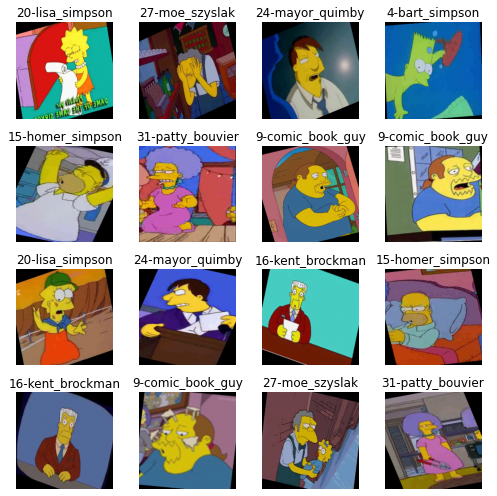

In [10]:
show_some_samples(DataLoader(train_dataset, batch_size=16, shuffle=True))

А теперь - как выглядит валидация.

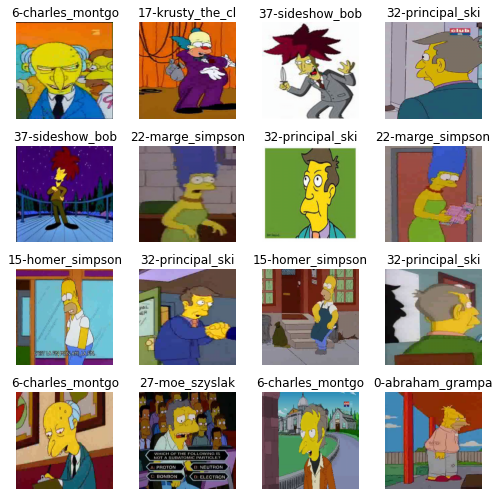

In [11]:
show_some_samples(DataLoader(val_dataset, batch_size=16, shuffle=True))

# Функции для обучения сети

In [12]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    gt = []
    predictions = []
  
    for i, (inputs, labels) in enumerate(train_loader):
        #print(str(i) + ' ', end='')
        gt.extend(labels.detach().numpy())
        inputs = inputs.to(DEVICE)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        predictions.extend(preds.cpu().detach().numpy())
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = accuracy_score(gt, predictions)
    train_f1 = f1_score(gt, predictions, average='macro')
    return train_loss, train_acc, train_f1

In [13]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    gt = []
    predictions = []

    for inputs, labels in val_loader:
        labels = labels.type(torch.LongTensor)
        gt.extend(labels.detach().numpy())
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            predictions.extend(preds.cpu().detach().numpy())

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = accuracy_score(gt, predictions)
    val_f1 = f1_score(gt, predictions, average='macro')
    return val_loss, val_acc, val_f1

In [14]:
def plot_train_curves(history):
    loss, acc, f1, val_loss, val_acc, val_f1, lr = zip(*history)
    fig = plt.figure(figsize=(10,12))
    fig.patch.set_facecolor('xkcd:white')
    plt.subplot(4,1,1)
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("loss")

    plt.subplot(4,1,2)
    plt.plot(acc, label="train_acc")
    plt.plot(val_acc, label="val_acc")
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("acc")

    plt.subplot(4,1,3)
    plt.plot(f1, label="train_f1")
    plt.plot(val_f1, label="val_f1")
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("f1")

    plt.subplot(4,1,4)
    plt.plot(lr, label="LR")
    plt.xlabel("epochs")
    plt.ylabel("LR")
    fig.tight_layout()

In [16]:
import copy
def train(train_files, val_files, model, epochs, batch_size, optimizer, scheduler=None, set_best_params=True):
    num_workers = 0
    train_dataset = SimpsonsDataset(train_files, mode='train')
    val_dataset = SimpsonsDataset(val_files, mode='val')

    # print('train samples')
    # show_some_samples(DataLoader(train_dataset, batch_size=16, shuffle=True))
    # print('val samples')
    # show_some_samples(DataLoader(val_dataset, batch_size=16, shuffle=True))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # train_loader = DataLoader(train_dataset, batch_size=batch_size,
    #                       sampler=torch.utils.data.WeightedRandomSampler(weights=class_weigts, num_samples=len(train_dataset), replacement=True))

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1_val = None
    history = []
    log_template = "Ep{ep:03d} tr_loss: {t_loss:0.4f} v_loss {v_loss:0.4f} tr_acc {t_acc:0.4f} v_acc {v_acc:0.4f} tr_f1 {t_f1:0.4f} v_f1 {v_f1:0.4f}"
    lr = 0

    opt = optimizer
    # расчет весов для потерь несбалансированных классов
    a = pd.Series(Counter(train_dataset.labels))
    a = torch.Tensor(1 / np.sqrt(a)).to(DEVICE)
    a / a.mean()
    criterion = nn.CrossEntropyLoss(a)

    for epoch in range(epochs):
        lr = optimizer.param_groups[0]["lr"]
        t1 = time.time()
        train_loss, train_acc, train_f1 = fit_epoch(model, train_loader, criterion, opt)
        val_loss, val_acc, val_f1 = eval_epoch(model, val_loader, criterion)

        if best_f1_val == None: best_f1_val = val_f1
        new_best = False
        if val_f1 > best_f1_val:
            new_best = True
            best_f1_val = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model, 'H:/Google_d/2022_DL_Stepik/Home_05_Simpsons/model' + f'{val_f1:.4}' + '.pt')

        history.append((train_loss, train_acc, train_f1, val_loss, val_acc, val_f1, lr))

        el_t = time.time() - t1
        el_t = f'{el_t // 60:.0f}m {el_t % 60:.0f}s'

        print(log_template.format(
            ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, t_f1=train_f1, v_f1=val_f1
        ), el_t, f'LR: {lr:.1e}', new_best*'[best]')

        if scheduler != None: scheduler.step(train_loss)

    if set_best_params: model.load_state_dict(best_model_wts)

    plot_train_curves(history)
    return history, best_model_wts

In [17]:
def predict(model, test_loader):
    model.eval()
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)

            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

# Модель

Теперь сама модель.

Попробовал много разных отсюда [https://pytorch.org/vision/stable/models.html](https://pytorch.org/vision/stable/models.html)

In [18]:
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))

we will classify :42


In [22]:
model = models.resnext50_32x4d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, n_classes)
model.to(DEVICE);

Запустим обучение сети. Будем постепенно размораживать слои.

Ep001 tr_loss: 10.9636 v_loss 3.9178 tr_acc 0.3865 v_acc 0.5353 tr_f1 0.2203 v_f1 0.2994 7m 4s LR: 3.0e-02 
Ep002 tr_loss: 4.1779 v_loss 5.6591 tr_acc 0.5212 v_acc 0.4453 tr_f1 0.3498 v_f1 0.2968 7m 8s LR: 3.0e-02 
Ep003 tr_loss: 4.4300 v_loss 4.7770 tr_acc 0.5419 v_acc 0.5845 tr_f1 0.3932 v_f1 0.3648 7m 1s LR: 3.0e-02 [best]
Ep004 tr_loss: 4.2500 v_loss 5.1284 tr_acc 0.5718 v_acc 0.5210 tr_f1 0.4160 v_f1 0.3590 6m 53s LR: 3.0e-02 
Ep005 tr_loss: 1.7758 v_loss 2.5349 tr_acc 0.7166 v_acc 0.6690 tr_f1 0.6065 v_f1 0.5117 7m 2s LR: 6.0e-03 [best]
Ep006 tr_loss: 1.5027 v_loss 2.2541 tr_acc 0.7283 v_acc 0.6704 tr_f1 0.6633 v_f1 0.4940 6m 26s LR: 6.0e-03 
Ep007 tr_loss: 1.4320 v_loss 2.2584 tr_acc 0.7252 v_acc 0.6981 tr_f1 0.6799 v_f1 0.5657 5m 25s LR: 6.0e-03 [best]
Ep008 tr_loss: 1.0174 v_loss 1.8109 tr_acc 0.7710 v_acc 0.7117 tr_f1 0.7404 v_f1 0.5765 6m 47s LR: 1.2e-03 [best]
Ep009 tr_loss: 0.9368 v_loss 1.7554 tr_acc 0.7804 v_acc 0.7124 tr_f1 0.7447 v_f1 0.5607 7m 0s LR: 1.2e-03 
Ep010 tr

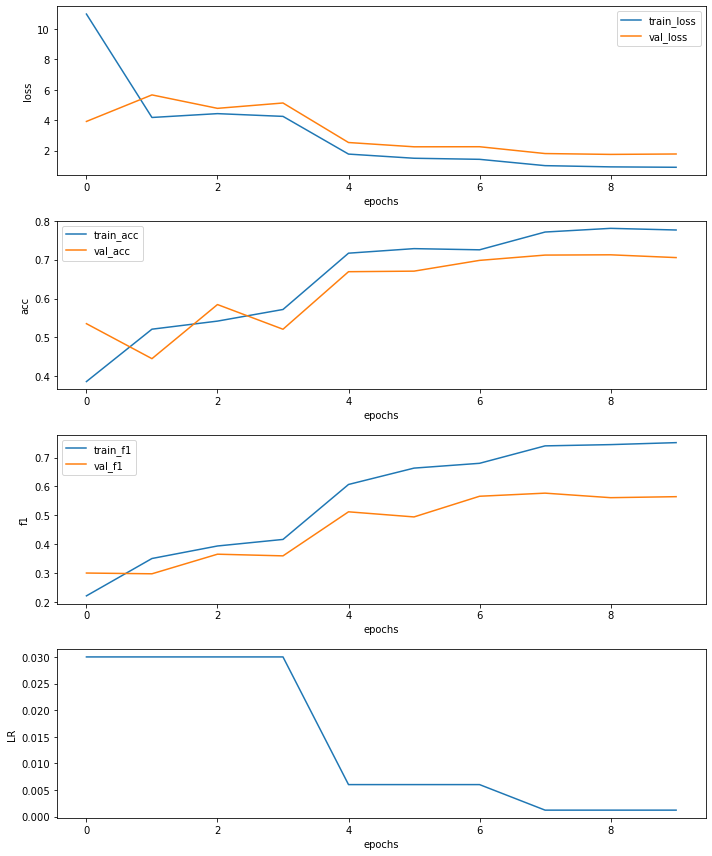

In [23]:
%%time
base_lr = 3e-2
epochs = 10
lr_decrease = 20
optimizer = torch.optim.AdamW([
    dict(params=model.fc.parameters(), lr=base_lr),
    #dict(params=model.classifier[3].parameters(), lr=base_lr),
    #{"params": model.layer4.parameters(), "lr": base_lr/lr_decrease},
    #{"params": model.layer3.parameters(), "lr": base_lr/lr_decrease/lr_decrease},
    #{"params": model.layer2.parameters(), "lr": base_lr/lr_decrease/lr_decrease/lr_decrease},
    #{"params": model.layer1.parameters(), "lr": base_lr/lr_decrease/lr_decrease/lr_decrease/lr_decrease},
])
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, step_size=3, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2)
history, best_model_wts = train(train_files=train_files, val_files=val_files, model=model, epochs=epochs, batch_size=64, optimizer=optimizer, scheduler=scheduler)

Ep001 tr_loss: 1.1566 v_loss 0.7268 tr_acc 0.8251 v_acc 0.8726 tr_f1 0.7003 v_f1 0.7021 6m 35s LR: 3.0e-03 
Ep002 tr_loss: 0.2245 v_loss 0.5415 tr_acc 0.9340 v_acc 0.9069 tr_f1 0.8743 v_f1 0.7891 7m 4s LR: 3.0e-03 [best]
Ep003 tr_loss: 0.1054 v_loss 0.4615 tr_acc 0.9622 v_acc 0.9291 tr_f1 0.9337 v_f1 0.8262 7m 7s LR: 3.0e-03 [best]
Ep004 tr_loss: 0.0801 v_loss 0.4248 tr_acc 0.9717 v_acc 0.9337 tr_f1 0.9524 v_f1 0.8304 6m 28s LR: 3.0e-03 [best]
Ep005 tr_loss: 0.0413 v_loss 0.3895 tr_acc 0.9829 v_acc 0.9444 tr_f1 0.9731 v_f1 0.8511 5m 18s LR: 6.0e-04 [best]
Ep006 tr_loss: 0.0217 v_loss 0.3807 tr_acc 0.9901 v_acc 0.9501 tr_f1 0.9894 v_f1 0.8668 5m 18s LR: 6.0e-04 [best]
CPU times: total: 54min 28s
Wall time: 37min 49s


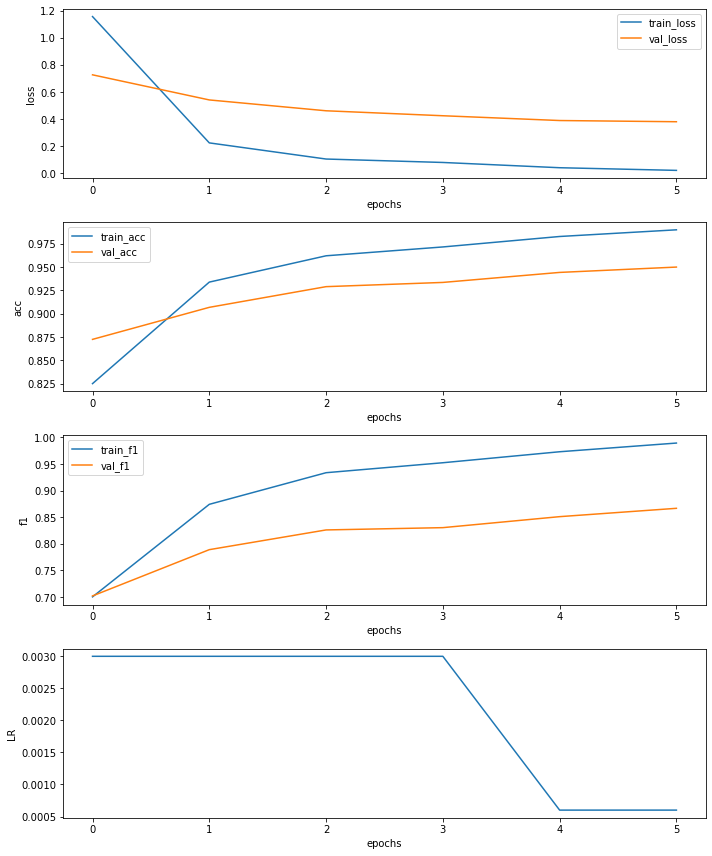

In [24]:
%%time
base_lr = 3e-3
epochs = 6
optimizer = torch.optim.AdamW([
    dict(params=model.fc.parameters(), lr=base_lr),
    {"params": model.layer4.parameters(), "lr": base_lr/lr_decrease},
    #{"params": model.layer3.parameters(), "lr": base_lr/lr_decrease/lr_decrease},
    #{"params": model.layer2.parameters(), "lr": base_lr/lr_decrease/lr_decrease/lr_decrease},
    #{"params": model.layer1.parameters(), "lr": base_lr/lr_decrease/lr_decrease/lr_decrease/lr_decrease},
])
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2)
history, best_model_wts = train(train_files=train_files, val_files=val_files, model=model, epochs=epochs, batch_size=64, optimizer=optimizer, scheduler=scheduler)

Ep001 tr_loss: 0.0463 v_loss 0.4559 tr_acc 0.9814 v_acc 0.9451 tr_f1 0.9714 v_f1 0.8494 5m 16s LR: 1.0e-03 
Ep002 tr_loss: 0.0328 v_loss 0.5064 tr_acc 0.9862 v_acc 0.9446 tr_f1 0.9768 v_f1 0.8797 5m 14s LR: 1.0e-03 [best]
Ep003 tr_loss: 0.0328 v_loss 0.4954 tr_acc 0.9868 v_acc 0.9451 tr_f1 0.9802 v_f1 0.8623 5m 16s LR: 1.0e-03 
Ep004 tr_loss: 0.0221 v_loss 0.4382 tr_acc 0.9925 v_acc 0.9494 tr_f1 0.9905 v_f1 0.8730 5m 15s LR: 1.0e-03 
Ep005 tr_loss: 0.0121 v_loss 0.4262 tr_acc 0.9952 v_acc 0.9518 tr_f1 0.9952 v_f1 0.8703 5m 15s LR: 2.0e-04 
Ep006 tr_loss: 0.0089 v_loss 0.4163 tr_acc 0.9964 v_acc 0.9551 tr_f1 0.9955 v_f1 0.8843 5m 15s LR: 2.0e-04 [best]
CPU times: total: 49min 43s
Wall time: 31min 32s


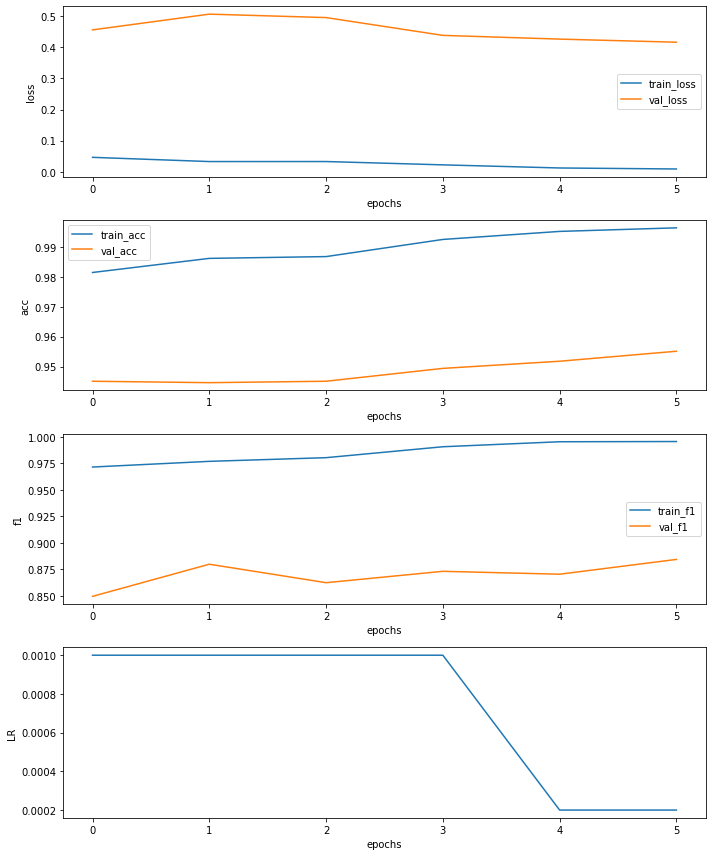

In [25]:
%%time
base_lr = 1e-3
optimizer = torch.optim.AdamW([
    dict(params=model.fc.parameters(), lr=base_lr),
    {"params": model.layer4.parameters(), "lr": base_lr/lr_decrease},
    {"params": model.layer3.parameters(), "lr": base_lr/lr_decrease/lr_decrease},
    #{"params": model.layer2.parameters(), "lr": base_lr/lr_decrease/lr_decrease/lr_decrease},
    #{"params": model.layer1.parameters(), "lr": base_lr/lr_decrease/lr_decrease/lr_decrease/lr_decrease},
])
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2)
history, best_model_wts = train(train_files=train_files, val_files=val_files, model=model, epochs=epochs, batch_size=64, optimizer=optimizer, scheduler=scheduler)

Ep001 tr_loss: 0.0060 v_loss 0.4261 tr_acc 0.9973 v_acc 0.9587 tr_f1 0.9972 v_f1 0.8912 5m 17s LR: 3.0e-04 
Ep002 tr_loss: 0.0064 v_loss 0.4475 tr_acc 0.9971 v_acc 0.9575 tr_f1 0.9965 v_f1 0.8914 5m 16s LR: 3.0e-04 [best]
Ep003 tr_loss: 0.0043 v_loss 0.4111 tr_acc 0.9984 v_acc 0.9570 tr_f1 0.9980 v_f1 0.8866 5m 17s LR: 3.0e-04 
Ep004 tr_loss: 0.0076 v_loss 0.4329 tr_acc 0.9978 v_acc 0.9566 tr_f1 0.9974 v_f1 0.8840 5m 16s LR: 3.0e-04 
Ep005 tr_loss: 0.0082 v_loss 0.4196 tr_acc 0.9972 v_acc 0.9578 tr_f1 0.9969 v_f1 0.8853 5m 14s LR: 3.0e-04 
Ep006 tr_loss: 0.0022 v_loss 0.4083 tr_acc 0.9991 v_acc 0.9589 tr_f1 0.9985 v_f1 0.8991 5m 15s LR: 3.0e-04 [best]
CPU times: total: 49min 41s
Wall time: 31min 36s


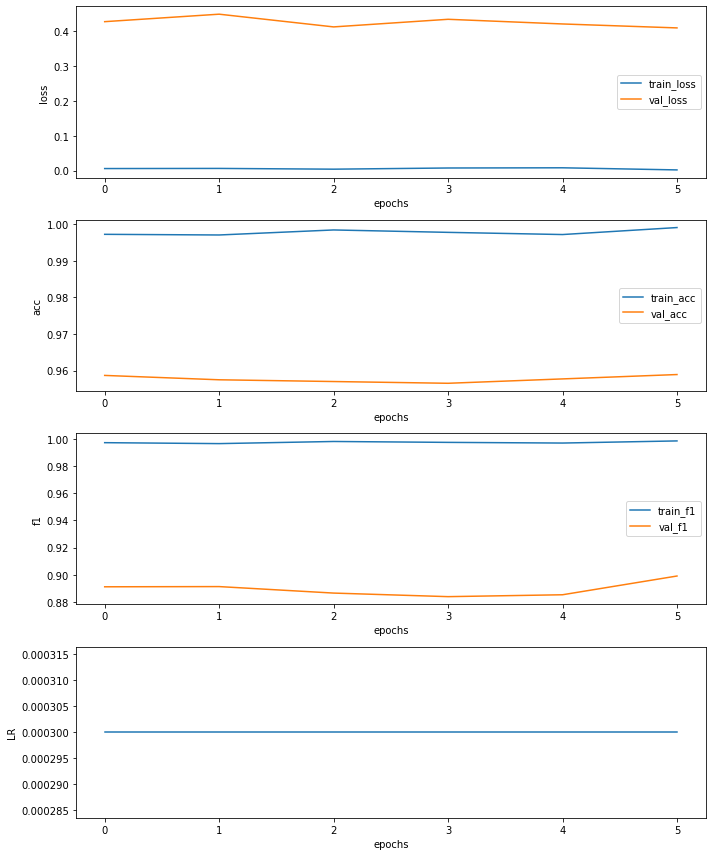

In [26]:
%%time
base_lr = 3e-4
optimizer = torch.optim.AdamW([
    dict(params=model.fc.parameters(), lr=base_lr),
    {"params": model.layer4.parameters(), "lr": base_lr/lr_decrease},
    {"params": model.layer3.parameters(), "lr": base_lr/lr_decrease/lr_decrease},
    {"params": model.layer2.parameters(), "lr": base_lr/lr_decrease/lr_decrease/lr_decrease},
    #{"params": model.layer1.parameters(), "lr": base_lr/lr_decrease/lr_decrease/lr_decrease/lr_decrease},
])
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2)
history, best_model_wts = train(train_files=train_files, val_files=val_files, model=model, epochs=epochs, batch_size=64, optimizer=optimizer, scheduler=scheduler)

# Анализ результатов

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [28]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [29]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [30]:
idxs = list(map(int, np.random.uniform(0, 1000, 50)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [31]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [32]:
f1_score(actual_labels, list(y_pred), average='macro')

0.9494949494949495

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

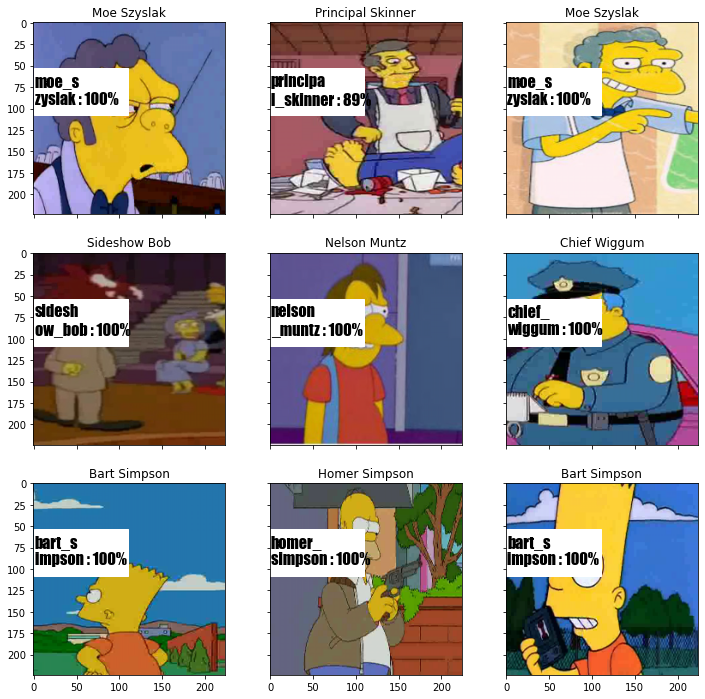

In [33]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),110,55,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=16, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

# Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [34]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [35]:
res = pd.DataFrame()
res['Id'] = test_filenames
res['Expected'] = preds

In [36]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit['num'] = my_submit['Id'].str.replace(r'[a-z.]+', '', regex=True).astype(int)
my_submit = my_submit.sort_values('num', ascending=True).reset_index(drop=True).drop('num', axis=1)
my_submit.head(10)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img2.jpg,mayor_quimby
3,img3.jpg,nelson_muntz
4,img4.jpg,lisa_simpson
5,img5.jpg,principal_skinner
6,img6.jpg,krusty_the_clown
7,img7.jpg,apu_nahasapeemapetilon
8,img8.jpg,principal_skinner
9,img9.jpg,comic_book_guy


In [37]:
my_submit.to_csv('Troschiev_01.csv', index=False)